In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Some sklearn stuff
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

sns.set(style="whitegrid")

In [2]:
# -----------------------------
# Milestone 1: Data Collection
# -----------------------------
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Let's see what the raw data looks like
print("Initial Dataset Head:")
print(df.head())

Initial Dataset Head:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovie

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

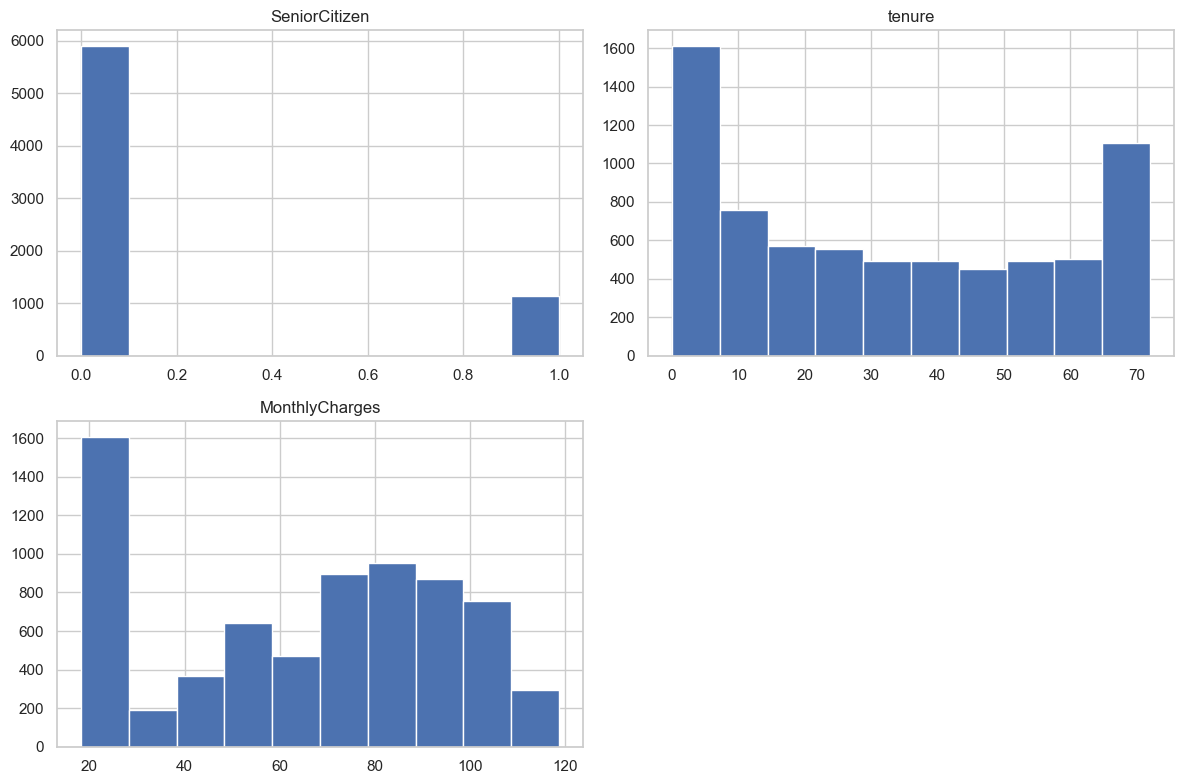

In [5]:
# Plot hist for numeric cols before any changes
numeric_cols_initial = df.select_dtypes(include=[np.number]).columns
df[numeric_cols_initial].hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

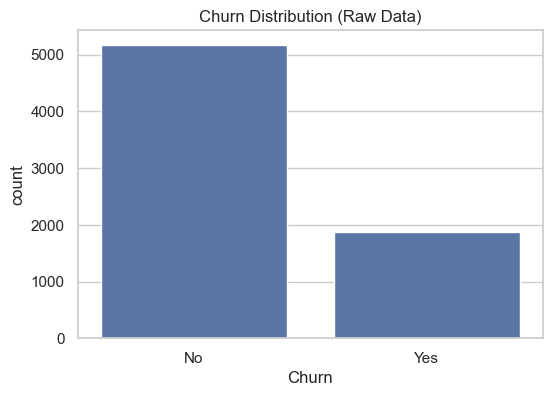

In [6]:
# Count plot for Churn target (raw)
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution (Raw Data)')
plt.show()

In [7]:
# -----------------------------
# Milestone 2: Data Cleaning 
# -----------------------------
# Convert TotalCharges to numeric, coerce errors to NaN then fill with median
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [8]:
# Fix col names: remove whitespace, make lower case, replace spaces with underscores
df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]

In [9]:
# Remove duplicate rows if any
df.drop_duplicates(inplace=True)
print("Cleaned dataset shape:", df.shape)

Cleaned dataset shape: (7043, 21)


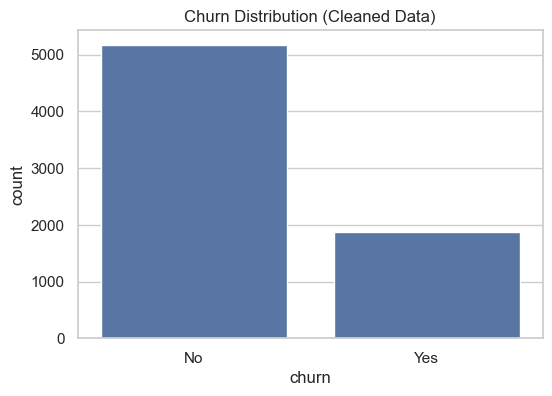

In [10]:
# -----------------------------
# Milestone 3: Exploratory Data Analysis 
# -----------------------------
# 1. Plot churn count (cleaned data now)
plt.figure(figsize=(6, 4))
sns.countplot(x='churn', data=df)
plt.title('Churn Distribution (Cleaned Data)')
plt.show()

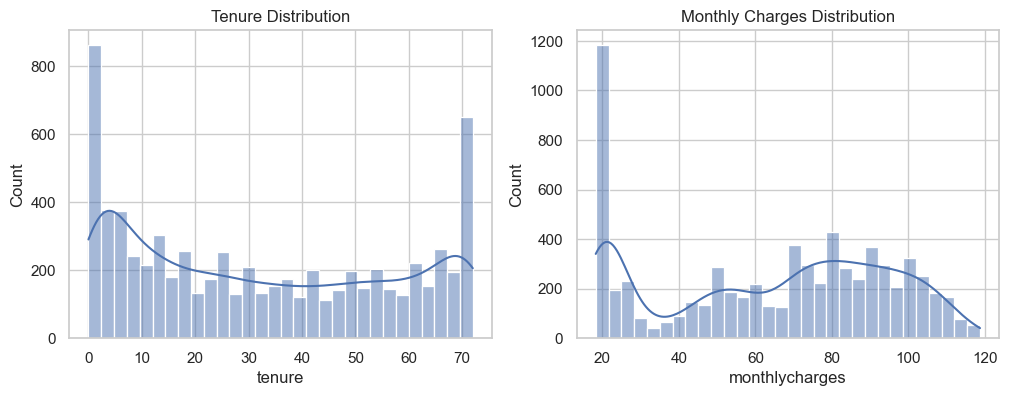

In [11]:
# 2. Plot histograms for two numeric features: tenure and monthlycharges
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['tenure'], bins=30, kde=True)
plt.title('Tenure Distribution')
plt.subplot(1, 2, 2)
sns.histplot(df['monthlycharges'], bins=30, kde=True)
plt.title('Monthly Charges Distribution')
plt.show()

In [12]:
# 3. Create a new feature: average charge per month (totalcharges/tenure)
df['avg_charge_per_month'] = df['totalcharges'] / df['tenure']
# if tenure==0, it may produce inf so replace those with 0
df['avg_charge_per_month'] = df['avg_charge_per_month'].replace([np.inf, -np.inf], np.nan).fillna(0)

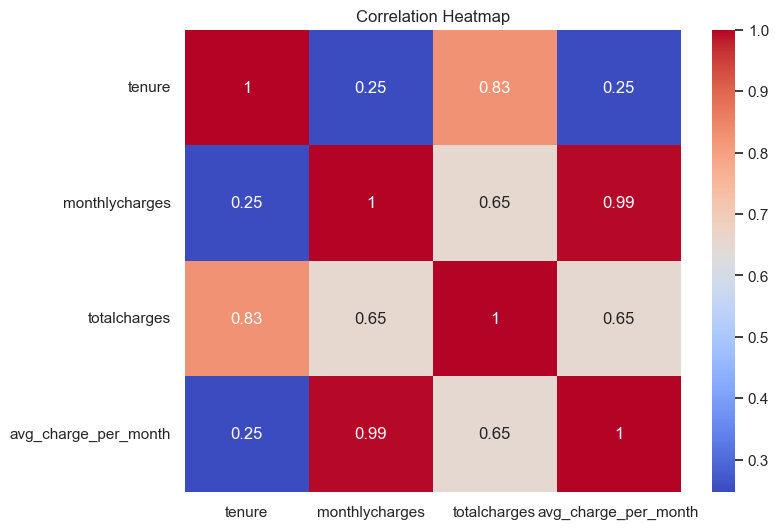

In [13]:
# 4. Draw a correlation heatmap for some numeric features
plt.figure(figsize=(8, 6))
sns.heatmap(df[['tenure', 'monthlycharges', 'totalcharges', 'avg_charge_per_month']].corr(), 
            annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

<Axes: xlabel='totalcharges', ylabel='tenure'>

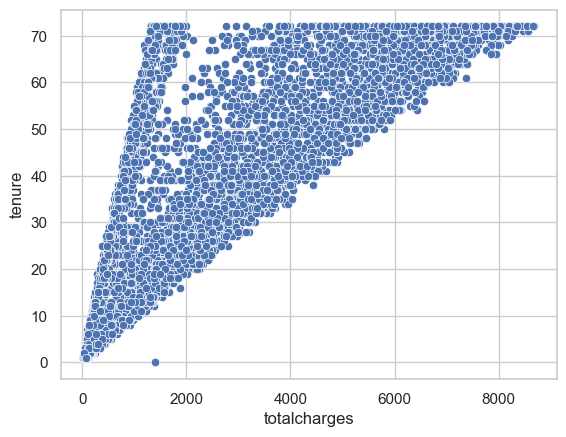

In [62]:

sns.scatterplot(x = df['totalcharges'], y = df['tenure'])

In [14]:
# -----------------------------
# Milestone 4: Data Preprocessing
# -----------------------------
# Remove non-feature columns (like customerid)
cols_to_drop = ['customerid']


df_preprocess = df.drop(columns=cols_to_drop)
print("Shape of preprocessed features:", df_preprocess.shape)

Shape of preprocessed features: (7043, 21)


In [15]:
# Get categorical columns (except churn) and numeric columns
categorical_cols = df_preprocess.select_dtypes(include=['object']).columns.tolist()
if 'churn' in categorical_cols:
    categorical_cols.remove('churn')
numerical_cols = df_preprocess.select_dtypes(include=[np.number]).columns.tolist()

print("Cat columns:", categorical_cols)
print("Num columns:", numerical_cols)

# Build a ColumnTransformer: scale numeric and one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# Fit and transform our data
X_preprocessed = preprocessor.fit_transform(df_preprocess)

# Convert churn to binary: Yes->1, No->0 (ignore case)
y = df['churn'].apply(lambda x: 1 if x.strip().lower() == 'yes' else 0)
y

Cat columns: ['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod']
Num columns: ['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges', 'avg_charge_per_month']


0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: churn, Length: 7043, dtype: int64

In [16]:
# -----------------------------
# Milestone 5: Model Development 
# -----------------------------
# Select features that correlate with churn. Here, we choose: tenure, monthlycharges, totalcharges.
selected_features = ['tenure', 'totalcharges']
X_model = df[selected_features]
y_model = y

# Split data into train and test (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=42)

# Train a logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Calculate and print out metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nLogistic Regression Metrics:")
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1 Score: {:.3f}".format(f1))


Logistic Regression Metrics:
Accuracy: 0.766
Precision: 0.583
Recall: 0.405
F1 Score: 0.478


In [17]:
# -----------------------------
# Milestone 6: Model Development 
# Here we visualize the decision boundary for two features
# We'll use tenure vs totalcharges instead of monthlycharges now.
# -----------------------------
df['churn_binary'] = y  # make a new col for binary churn

# 1. Choose two features for visualization
X_vis = df[['tenure', 'totalcharges']]
y_vis = df['churn_binary']

In [18]:
# 2. Split data for a simple logistic regression visualization
X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(
    X_vis, y_vis, test_size=0.2, random_state=42
)
logreg_vis = LogisticRegression(max_iter=1000)
logreg_vis.fit(X_train_vis, y_train_vis)

LogisticRegression(max_iter=1000)

In [19]:
# 3. Create a mesh grid for plotting the decision boundary
x_min, x_max = X_vis['tenure'].min() - 1, X_vis['tenure'].max() + 1
y_min, y_max = X_vis['totalcharges'].min() - 1, X_vis['totalcharges'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

In [20]:
# 4. Make a temporary DataFrame so the predict function sees correct col names
mesh_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=['tenure', 'totalcharges'])
Z = logreg_vis.predict(mesh_data).reshape(xx.shape)

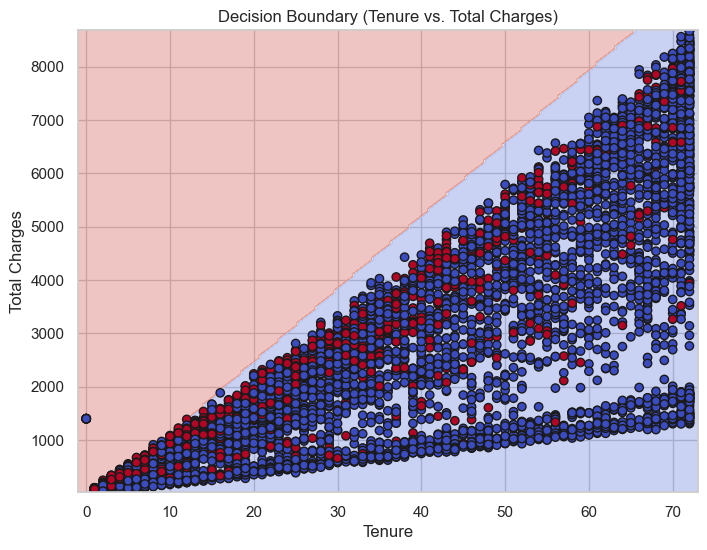

In [21]:
# 5. Plot the decision boundary with scatter of the data points
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_vis['tenure'], X_vis['totalcharges'], c=y_vis, cmap='coolwarm', edgecolor='k')
plt.xlabel('Tenure')
plt.ylabel('Total Charges')
plt.title('Decision Boundary (Tenure vs. Total Charges)')
plt.show()

In [22]:
# -----------------------------
# Milestone 7: K-Means Clustering 
# -----------------------------

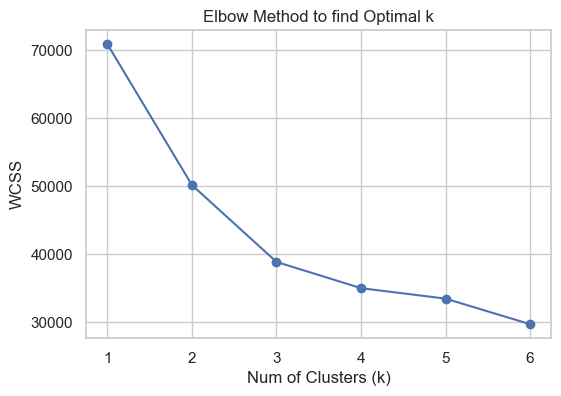

In [23]:
# Use the elbow method to decide the best number of clusters (WCSS)
wcss = []
for i in range(1, 7):
    kmeans_elbow = KMeans(n_clusters=i, random_state=42)
    kmeans_elbow.fit(X_preprocessed)
    wcss.append(kmeans_elbow.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(range(1, 7), wcss, marker='o')
plt.xlabel('Num of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method to find Optimal k')
plt.show()

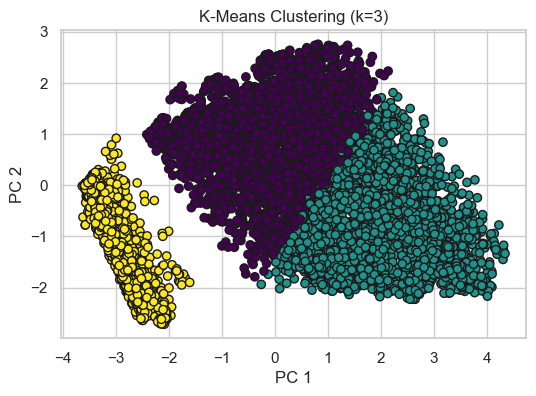

In [58]:
# Let's assume the elbow plot suggests k=3
optimal_k = 3
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans_final.fit_predict(X_preprocessed)

# Add cluster info to our DataFrame
df['Cluster'] = clusters

# Use PCA to reduce dimensions to 2 for a nice scatter plot of clusters
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_preprocessed)

plt.figure(figsize=(6, 4))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis', edgecolor='k')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('K-Means Clustering (k=3)')
plt.show()